# Stock Market Analysis: Tech Giants Performance
## Analyzing correlations and trends in major tech stocks

**Data Source:** Polygon.io API  
**Analysis Focus:** AAPL, MSFT, GOOGL, META, NVDA price movements and correlations  
**Time Period:** Last 2 years

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import requests

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
# Polygon.io API credentials
POLYGON_api_key = 'YOUR_API_KEY'

# Stock tickers to analyze
tickers = ['AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA']

# Date range (last 2 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

Fetching data from 2023-10-02 to 2025-10-01


In [3]:
# Function to fetch stock data from Polygon.io
def fetch_stock_data(ticker, start, end, api_key):
    """
    Fetch historical stock data from Polygon.io
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start}/{end}"
    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'apiKey': api_key
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        if 'results' in data:
            df = pd.DataFrame(data['results'])
            df['ticker'] = ticker
            df['date'] = pd.to_datetime(df['t'], unit='ms')
            return df[['date', 'ticker', 'o', 'h', 'l', 'c', 'v']].rename(columns={
                'o': 'open',
                'h': 'high',
                'l': 'low',
                'c': 'close',
                'v': 'volume'
            })
    return None

# Fetch data for all tickers
all_data = []
for ticker in tickers:
    print(f"Fetching {ticker}...")
    df = fetch_stock_data(
        ticker,
        start_date.strftime('%Y-%m-%d'),
        end_date.strftime('%Y-%m-%d'),
        POLYGON_API_KEY
    )
    if df is not None:
        all_data.append(df)
        print(f"  ✓ Got {len(df)} days of data")

# Combine all data
stock_data = pd.concat(all_data, ignore_index=True)
print(f"\nTotal records: {len(stock_data)}")

Fetching AAPL...


  ✓ Got 501 days of data
Fetching MSFT...


  ✓ Got 501 days of data
Fetching GOOGL...
  ✓ Got 501 days of data
Fetching META...


  ✓ Got 501 days of data
Fetching NVDA...


  ✓ Got 501 days of data

Total records: 2505


In [4]:
# Save raw data
stock_data.to_csv('../data/raw/stock_market_data.csv', index=False)
print("Data saved to data/raw/stock_market_data.csv")

Data saved to data/raw/stock_market_data.csv


In [5]:
# Basic data inspection
print("First few rows:")
print(stock_data.head())
print("\nData info:")
print(stock_data.info())
print("\nBasic statistics:")
print(stock_data.describe())

First few rows:
                 date ticker     open    high     low   close      volume
0 2023-10-02 04:00:00   AAPL  171.220  174.30  170.93  173.75  52164535.0
1 2023-10-03 04:00:00   AAPL  172.255  173.63  170.82  172.40  49594613.0
2 2023-10-04 04:00:00   AAPL  171.090  174.21  170.97  173.66  53020286.0
3 2023-10-05 04:00:00   AAPL  173.790  175.45  172.68  174.91  48527918.0
4 2023-10-06 04:00:00   AAPL  173.800  177.99  173.18  177.49  57266675.0

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2505 non-null   datetime64[ns]
 1   ticker  2505 non-null   object        
 2   open    2505 non-null   float64       
 3   high    2505 non-null   float64       
 4   low     2505 non-null   float64       
 5   close   2505 non-null   float64       
 6   volume  2505 non-null   float64       
dtypes: datetime64[ns](1),

In [6]:
# Calculate daily returns for each stock
stock_data['daily_return'] = stock_data.groupby('ticker')['close'].pct_change()

# Pivot data for correlation analysis
pivot_close = stock_data.pivot(index='date', columns='ticker', values='close')
pivot_returns = stock_data.pivot(index='date', columns='ticker', values='daily_return')

print("Pivoted data shape:", pivot_close.shape)
print(pivot_close.head())

Pivoted data shape: (501, 5)
ticker                 AAPL   GOOGL    META     MSFT    NVDA
date                                                        
2023-10-02 04:00:00  173.75  134.17  306.82  321.800  44.782
2023-10-03 04:00:00  172.40  132.43  300.94  313.390  43.517
2023-10-04 04:00:00  173.66  135.24  305.58  318.955  44.041
2023-10-05 04:00:00  174.91  135.07  304.79  319.360  44.688
2023-10-06 04:00:00  177.49  137.58  315.43  327.260  45.762


In [7]:
# Calculate correlation matrix
correlation_matrix = pivot_returns.corr()

print("Stock Price Correlation Matrix:")
print(correlation_matrix)

Stock Price Correlation Matrix:
ticker      AAPL     GOOGL      META      MSFT      NVDA
ticker                                                  
AAPL    1.000000  0.451600  0.405024  0.504669  0.372163
GOOGL   0.451600  1.000000  0.470575  0.510891  0.418243
META    0.405024  0.470575  1.000000  0.620030  0.486191
MSFT    0.504669  0.510891  0.620030  1.000000  0.547412
NVDA    0.372163  0.418243  0.486191  0.547412  1.000000


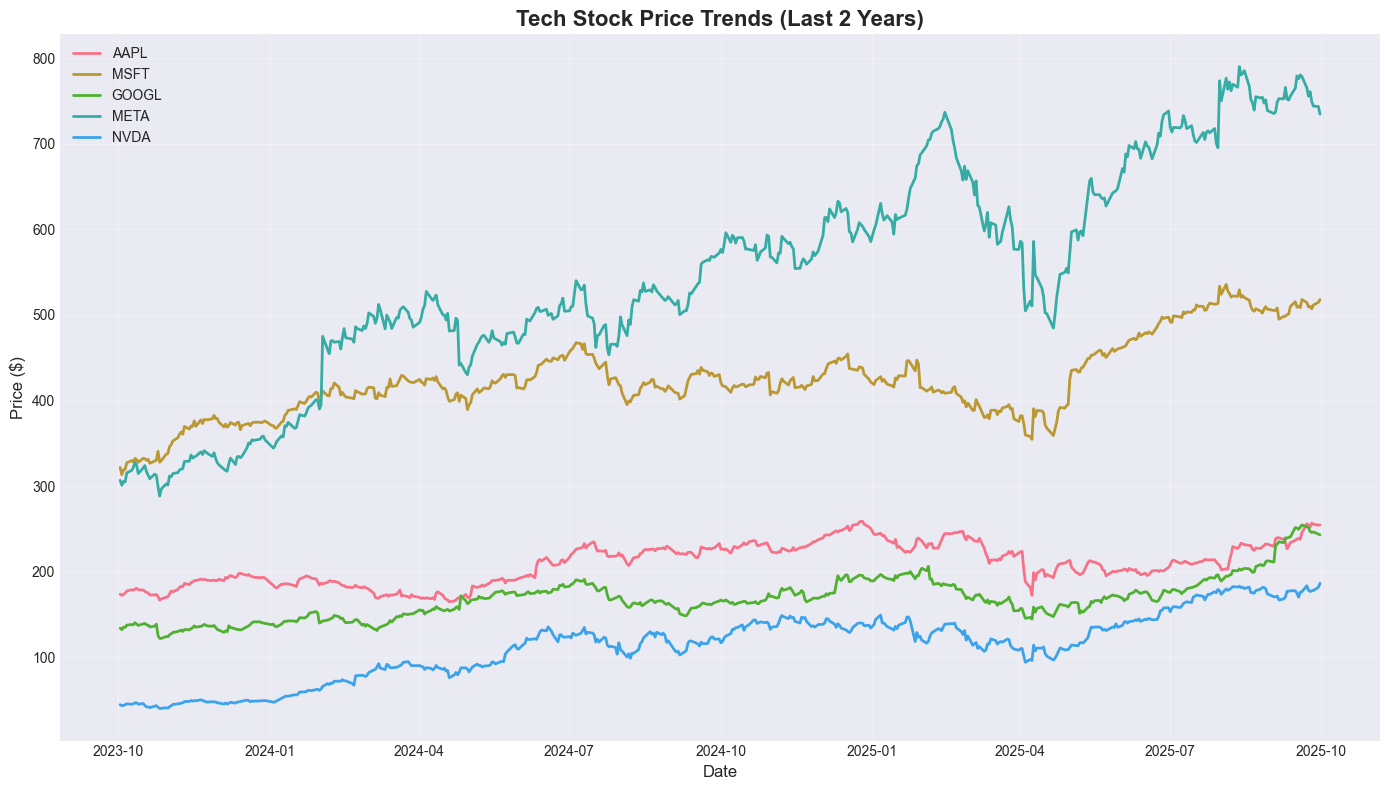

In [8]:
# Exploratory visualization: Price trends
plt.figure(figsize=(14, 8))
for ticker in tickers:
    data = stock_data[stock_data['ticker'] == ticker]
    plt.plot(data['date'], data['close'], label=ticker, linewidth=2)

plt.title('Tech Stock Price Trends (Last 2 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/static/stock_price_trends_raw.png', dpi=300, bbox_inches='tight')
plt.show()

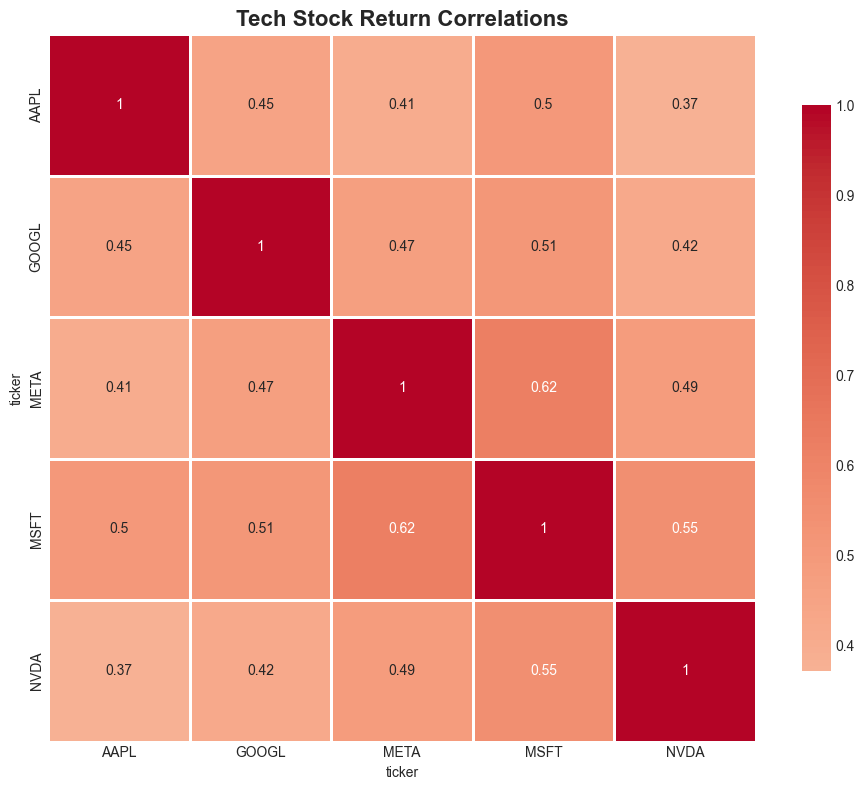

In [9]:
# Exploratory visualization: Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Tech Stock Return Correlations', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../visualizations/static/stock_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

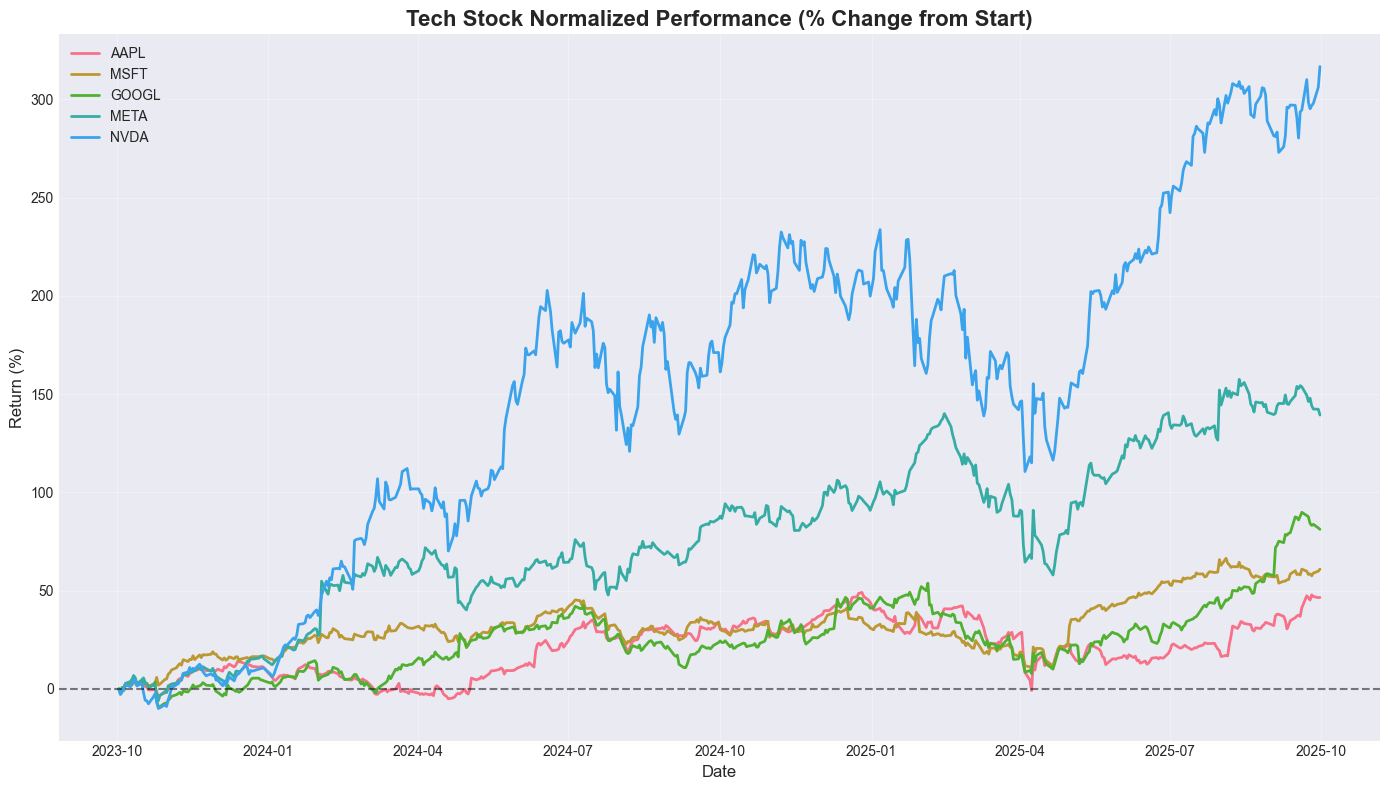

In [10]:
# Calculate normalized returns (percentage change from start)
normalized_data = pivot_close.copy()
for col in normalized_data.columns:
    normalized_data[col] = (normalized_data[col] / normalized_data[col].iloc[0] - 1) * 100

# Plot normalized performance
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(normalized_data.index, normalized_data[ticker], label=ticker, linewidth=2)

plt.title('Tech Stock Normalized Performance (% Change from Start)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Return (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../visualizations/static/stock_normalized_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Save processed data
stock_data.to_csv('../data/processed/stock_market_processed.csv', index=False)
correlation_matrix.to_csv('../data/processed/stock_correlations.csv')
print("Processed data saved!")

Processed data saved!


## Key Findings (To be updated after running analysis)

1. **Correlation Analysis**: [To be filled]
2. **Performance Leaders**: [To be filled]
3. **Volatility Patterns**: [To be filled]

## Next Steps
- Create polished visualization for portfolio
- Develop interactive Plotly charts
- Write detailed analysis narrative